In [7]:
import os, sys

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from utils import tokenize, remove_stopwords, stemming

In [8]:
data = pd.read_csv("../data/text.csv").drop(columns=['Unnamed: 0'])
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [9]:
print(f"Number of data entries: {len(data)}")

Number of data entries: 416809


In [10]:
emotion_map = {0:"sadness", 1:"joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}

### Label Distribution

In [11]:
labels = [emotion_map[label] for label in data['label']]
label_distribution = Counter(labels)

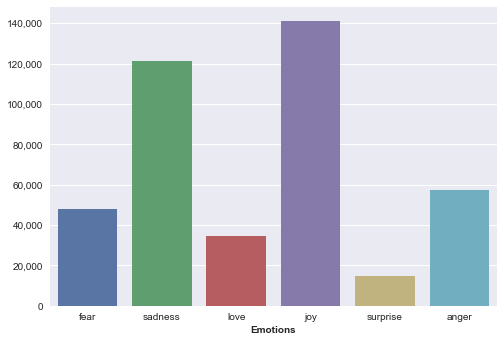

In [12]:
plt.style.use("seaborn")
plot = sns.barplot(x= list(label_distribution.keys()), y= list(label_distribution.values()))
plot.set_xlabel("Emotions",fontdict={"fontsize":10,"fontweight":"bold"});
plot.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));
# plot.ticklabel_format(axis="y",style='plain')

### Sentence lengths

In [13]:
data['tokens_stemm'] = data['text'].apply(tokenize).apply(remove_stopwords).apply(stemming)
# data['tokens_stemm'] = data['tokens']
data = data[~(data['tokens_stemm'].apply(len) == 0)]

In [14]:
data['sent_len'] = [len(sent_tok) for sent_tok in data['tokens_stemm']]
# data.to_csv("../data/text_tokenized.csv")

Mean Length = 9.36
Max Length = 79
99% quantile = 25


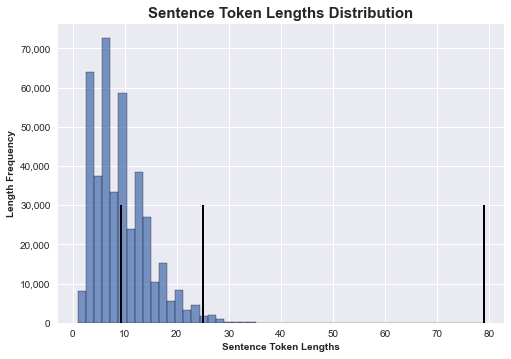

In [16]:
sent_lens_histogram = sns.histplot(data=data, x= 'sent_len', bins= 50);

sent_lens_histogram.set_xlabel("Sentence Token Lengths",fontdict={"fontsize":10,"fontweight":"bold"});
sent_lens_histogram.set_ylabel("Length Frequency", fontdict={"fontsize":10,"fontweight":"bold"});
sent_lens_histogram.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));
sent_lens_histogram.set_title("Sentence Token Lengths Distribution", fontdict={"fontsize":15,"fontweight":"bold"})

q = 0.99
mean_len = data['sent_len'].mean()
max_len = data['sent_len'].max()
quantile_len = data['sent_len'].quantile(q)

sent_lens_histogram.vlines([mean_len, max_len, quantile_len], ymin=0, ymax=30_000,
                           linestyles='solid',linewidth=2, colors='black')
print(f"Mean Length = {mean_len:.2f}")
print(f"Max Length = {max_len:.0f}")
print(f"{q*100:.0f}% quantile = {quantile_len:.0f}")

In [17]:
data[data['sent_len'] > data['sent_len'].quantile(0.99)]

,text,label,tokens_stemm,sent_len
24,i would imagine this is just one of the reason...,0,"[would, imagin, one, reason, marriag, hard, th...",26
116,i really love reading bible because i can feel...,5,"[realli, love, read, bibl, feel, presenc, lord...",27
175,i know the signs elevated resting heart rate m...,3,"[know, sign, elev, rest, heart, rate, mood, sw...",29
290,i must say i feel a little jaded because my or...,0,"[must, say, feel, littl, jade, organis, heart,...",29
340,i get to go to mass every day and that i met t...,4,"[get, go, mass, everi, day, met, super, kind, ...",28
...,...,...,...,...
416484,i learned two things that power including the ...,4,"[learn, two, thing, power, includ, power, hit,...",26
416561,i guess ive been a little bit in denial but i ...,4,"[guess, ive, littl, bit, denial, suddenli, rea...",29
416638,ive used on my blog i so very wisely decided t...,1,"[ive, use, blog, wise, decid, phone, blog, cou...",28
416715,i did not realize i was feeling this until it ...,1,"[realiz, feel, becam, pattern, would, feel, me...",30


## Create train, test and validation splits

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data['tokens_stemm'], data['label'], test_size=0.2, random_state=42)

In [20]:
index_map = {v: k for k, v in emotion_map.items()}

def doit(d, order):
  return  {k: d[k] for k in sorted(order, key=order.get)}

In [21]:
labels = [emotion_map[label] for label in y_train]
label_train = doit(Counter(labels), index_map)
labels = [emotion_map[label] for label in y_test]
label_test = doit(Counter(labels), index_map)

In [22]:
label_test

{'sadness': 24410,
 'joy': 28220,
 'love': 6892,
 'anger': 11423,
 'fear': 9399,
 'surprise': 3015}

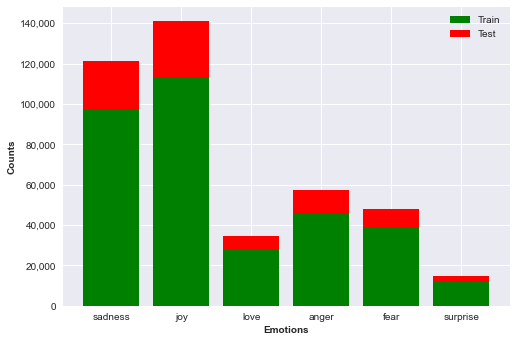

In [23]:
plt.style.use("seaborn")
fig, ax = plt.subplots()

ax.bar(list(label_train.keys()), list(label_train.values()), label="Train", color='green');
ax.bar(list(label_test.keys()), list(label_test.values()),
       bottom= list(label_train.values()), label="Test", color="red");

ax.legend(loc='best')
# plot = sns.barplot(x= list(label_train.keys()), y= list(label_train.values()),color='green',alpha=0.7)
# sns.barplot(x= list(label_train.keys()), y= list(label_train.values()),color='green',alpha=0.7)
ax.set_xlabel("Emotions",fontdict={"fontsize":10,"fontweight":"bold"});
ax.set_ylabel("Counts",fontdict={"fontsize":10,"fontweight":"bold"});
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

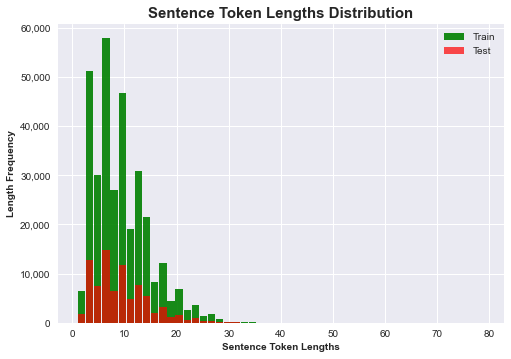

In [24]:
fig, ax = plt.subplots()

bin_height, bin_width, _ = ax.hist(x= [len(toks) for toks in x_train], bins=50, rwidth=0.9, label="Train", color="green",alpha= 0.9);
ax.hist(x= [len(toks) for toks in x_test], bins=bin_width, rwidth=0.9, label="Test", color="red",alpha= 0.7);

ax.set_xlabel("Sentence Token Lengths",fontdict={"fontsize":10,"fontweight":"bold"});
ax.set_ylabel("Length Frequency", fontdict={"fontsize":10,"fontweight":"bold"});
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));
ax.set_title("Sentence Token Lengths Distribution", fontdict={"fontsize":15,"fontweight":"bold"});

ax.legend(loc='best');

# Class Weights Balance


In [18]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

In [19]:
class_weights

{0: 0.5730663293598962,
 1: 0.4920821379801581,
 2: 2.0206929429065466,
 3: 1.2151846452866861,
 4: 1.4487099278208382,
 5: 4.656556064499311}